In [3]:
# 1 - imports and settings
import os
os.makedirs("plots", exist_ok=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, validation_curve, cross_validate
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, classification_report, confusion_matrix
)
import warnings
warnings.filterwarnings("ignore")

In [4]:
# 2 - load dataset (update path if needed)
DATA_PATH = r"D:\Buildables Internship\BuildablesDataScienceFellowship\Task#13\dataset\titanic_data.csv"
df = pd.read_csv(DATA_PATH)
print("Columns:", df.columns.tolist())
# Drop rows with missing target, if any
df = df.dropna(subset=['Survived']).reset_index(drop=True)
print("Rows after dropping missing Survived:", df.shape[0])
df.head()


Columns: ['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title', 'Family_Size']
Rows after dropping missing Survived: 891


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Family_Size
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,1
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,1
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,0


In [6]:
# 3 - preprocessing
# keep simple, explainable features
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
target = 'Survived'

# Select and impute
df = df[features + [target]].copy()
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# confirm no nulls remain
print(df.isnull().sum())

X = df[features]
y = df[target].astype(int)

numeric_features = ['Age','SibSp','Parch','Fare','Pclass']
categorical_features = ['Sex','Embarked']

numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('onehot', OneHotEncoder(drop='first', sparse_output=False))])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
])


Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64


In [7]:
# 4 - Logistic Regression single-split vs CV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

lr = Pipeline([('preprocess', preprocessor), ('clf', LogisticRegression(max_iter=1000))])
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
single_metrics_lr = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr, X, y, cv=cv, scoring='accuracy')

print("LR - single-split metrics:", single_metrics_lr)
print("LR - 5-fold CV accuracy scores:", cv_scores)
print("LR - mean CV accuracy:", np.mean(cv_scores))


LR - single-split metrics: {'accuracy': 0.8100558659217877, 'precision': 0.7966101694915254, 'recall': 0.6811594202898551, 'f1': 0.734375}
LR - 5-fold CV accuracy scores: [0.78212291 0.80337079 0.78651685 0.79213483 0.81460674]
LR - mean CV accuracy: 0.7957504237022158


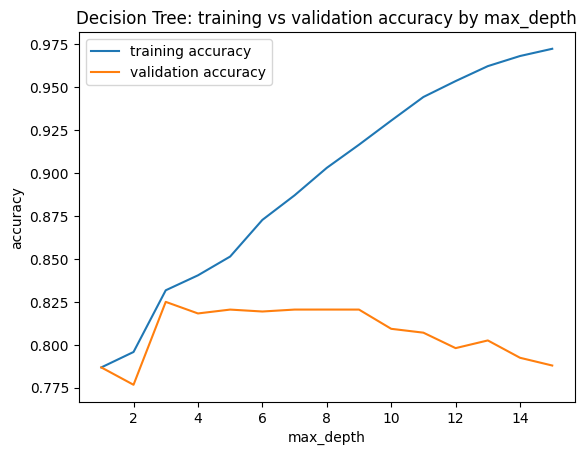

Optimal depth (validation): 3


In [8]:
# 5 - decision tree validation curve (bias-variance)
depths = np.arange(1, 16)   # 1..15 is usually enough
X_pre = preprocessor.fit_transform(X)   # validation_curve needs array input
train_scores, val_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_pre, y,
    param_name='max_depth',
    param_range=depths,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=1
)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure()
plt.plot(depths, train_mean, label='training accuracy')
plt.plot(depths, val_mean, label='validation accuracy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.title('Decision Tree: training vs validation accuracy by max_depth')
plt.savefig("plots/dt_depth_plot.png")
plt.show()

opt_idx = np.argmax(val_mean)
opt_depth = depths[opt_idx]
print("Optimal depth (validation):", opt_depth)
